In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import shap
import logging
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc
from mumu.model._evaluate import plot_all, plot_ks_auc, plot_slopping, plot_score_dist

In [27]:
df = pd.read_csv("../data/train.csv")
df_oot = pd.read_csv("../data/oot.csv")

In [20]:
# df["dun_case_id"] = df["dun_case_id"].map(lambda x: x + 10086)
# df_oot["dun_case_id"] = df_oot["dun_case_id"].map(lambda x: x + 10086)

In [26]:

# df.columns = ["id", "dt", "target",
#               'nv_var1', 'nv_var2', 'nv_var3', 'nv_var4',
#               'nv_var5','nv_var6', 'nv_var7', 'nv_var8',
#               'nv_var9', 'nv_var10', 'nv_var11', 'cv_var12']

# df.to_csv("../data/train.csv", index=False, encoding="utf8")
# df_oot.to_csv("../data/oot.csv", index=False, encoding="utf8")

# 字段类型转换

In [29]:
num_cols = [
    'nv_var1', 'nv_var2', 'nv_var3', 'nv_var4',
    'nv_var5','nv_var6', 'nv_var7', 'nv_var8',
    'nv_var9', 'nv_var10', 'nv_var11'
]

cat_cols = ['cv_var12']

for col in num_cols:
    df[col] = df[col].astype(float)
    df_oot[col] = df_oot[col].astype(float)


for col in cat_cols:
    df[col] = df[col].astype("category")
    df_oot[col] = df_oot[col].astype("category")

# 训练 LGBM

In [30]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df['target'])
model_cols = num_cols + cat_cols

params = {
    'boosting': "gbdt",
    'num_leaves': 10,
    'objective': 'binary',
    'max_depth': 4,
    'learning_rate': 0.005,
    'min_gain_to_split': 35,
    'max_bin': 10,
    'max_cat_threshold': 5,
    'bagging_fraction': 0.8,
    'bagging_freq': 10,
    'feature_fraction': [0.8],
    'min_data_in_leaf': [500],
    # 'lambda_L1': [0.01],
    'seed': [30],
    # 'scale_pos_weight': 0.01,
    'metric': ['auc', 'binary_logloss']
}

train_data = lgb.Dataset(train[model_cols], label=train['target'])
lgbm = lgb.train(params=params, train_set=train_data, valid_sets=[train_data],
                      num_boost_round=3000, early_stopping_rounds=100, verbose_eval=500)

[LightGBM] [Info] Number of positive: 7579, number of negative: 47477
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141
[LightGBM] [Info] Number of data points in the train set: 55056, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.137660 -> initscore=-1.834864
[LightGBM] [Info] Start training from score -1.834864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

# 查看 SHAP 值

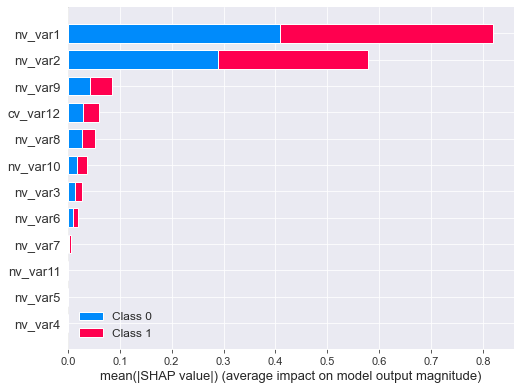

In [31]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(train[model_cols])
shap.summary_plot(shap_values, train[model_cols], max_display=30)

# 模型评价

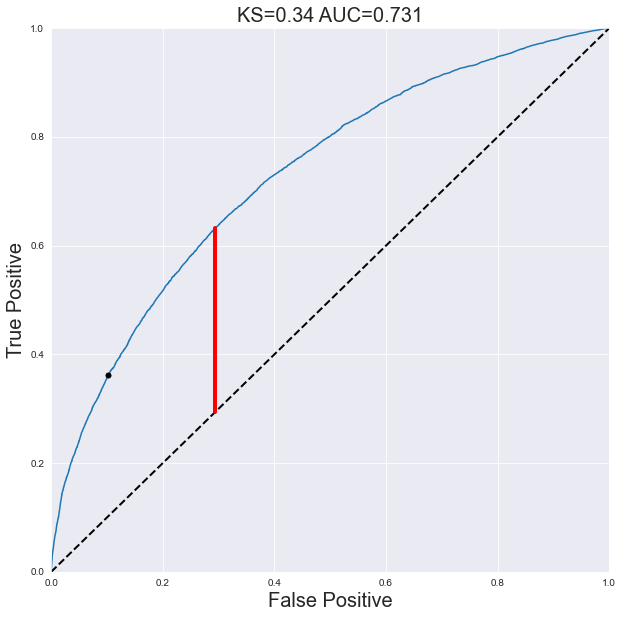

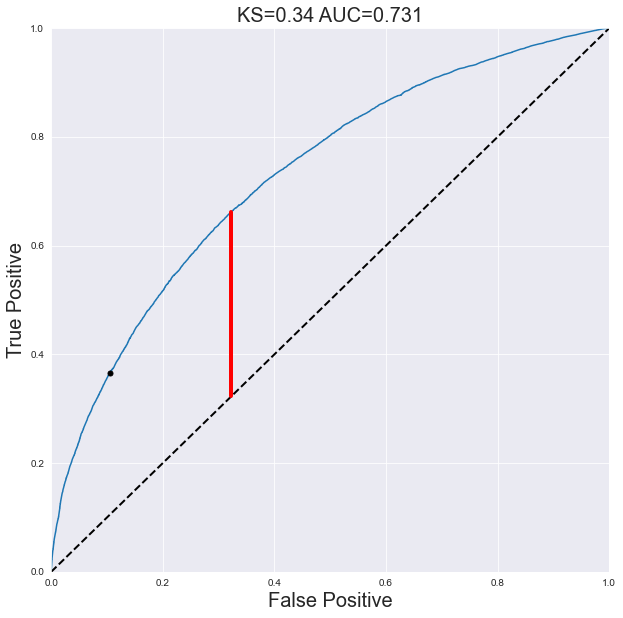

In [10]:
y_train_pred = lgbm.predict(train[model_cols].reset_index(drop=True))
y_oot_pred = lgbm.predict(df_oot[model_cols].reset_index(drop=True))

train_auc = plot_ks_auc(target=train['target'].reset_index(drop=True), predicted=y_train_pred)
oot_auc = plot_ks_auc(target=df_oot['target'].reset_index(drop=True), predicted=y_oot_pred)

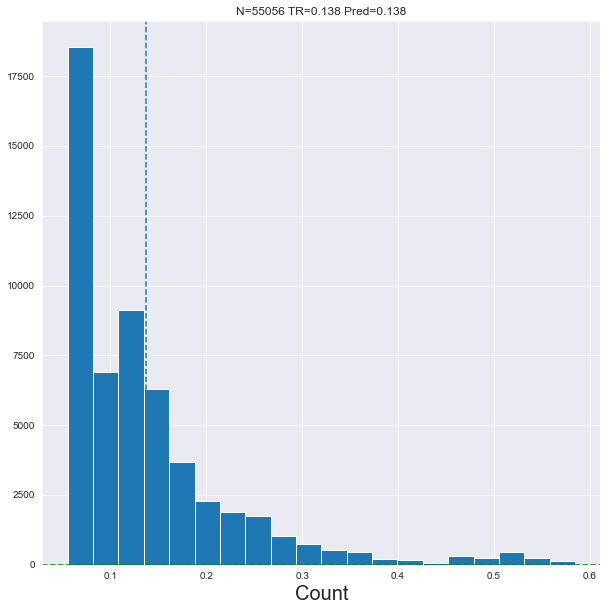

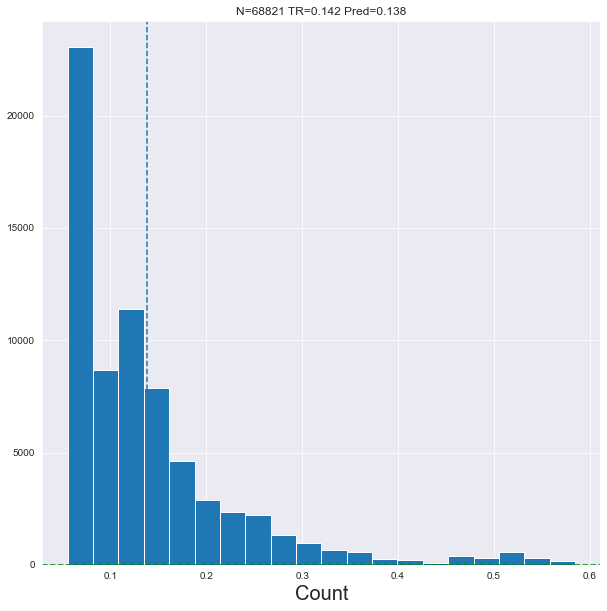

In [12]:
train_score_dist = plot_score_dist(target=train['target'].reset_index(drop=True), predicted=y_train_pred)
oot_score_dist = plot_score_dist(target=df_oot['target'].reset_index(drop=True), predicted=y_oot_pred)

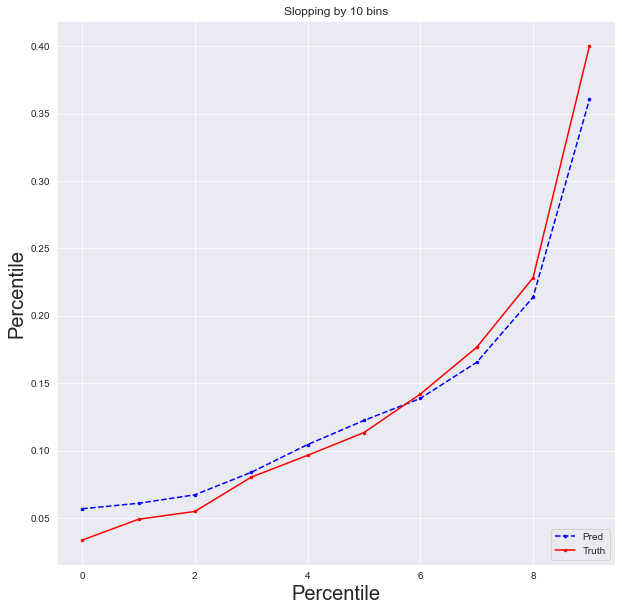

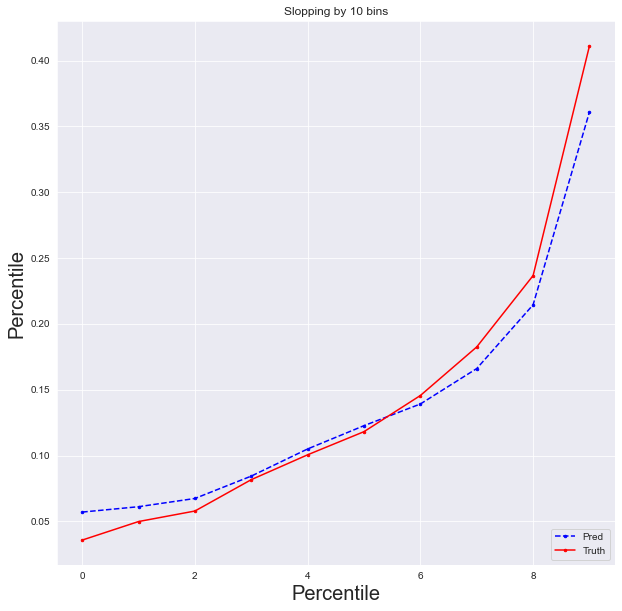

In [13]:
train_slopping = plot_slopping(target=train['target'].reset_index(drop=True), predicted=y_train_pred)
oot_slooping = plot_slopping(target=df_oot['target'].reset_index(drop=True), predicted=y_oot_pred)

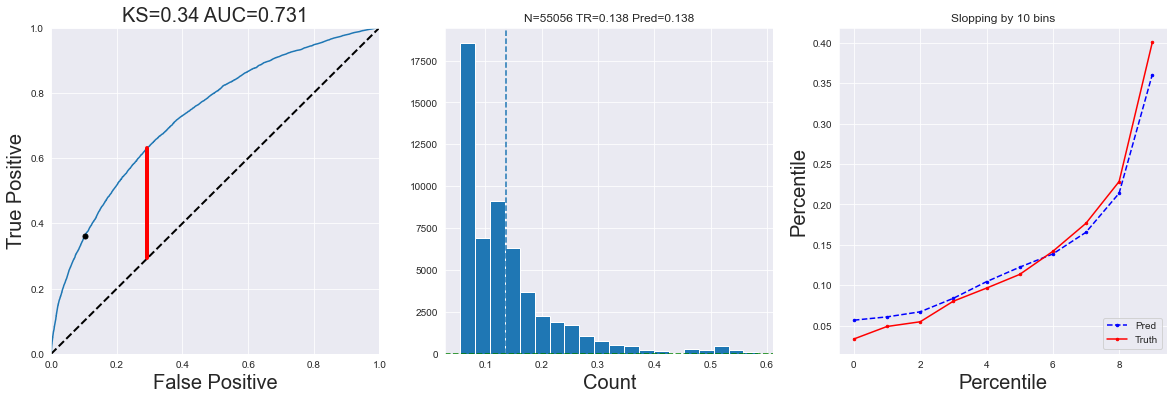

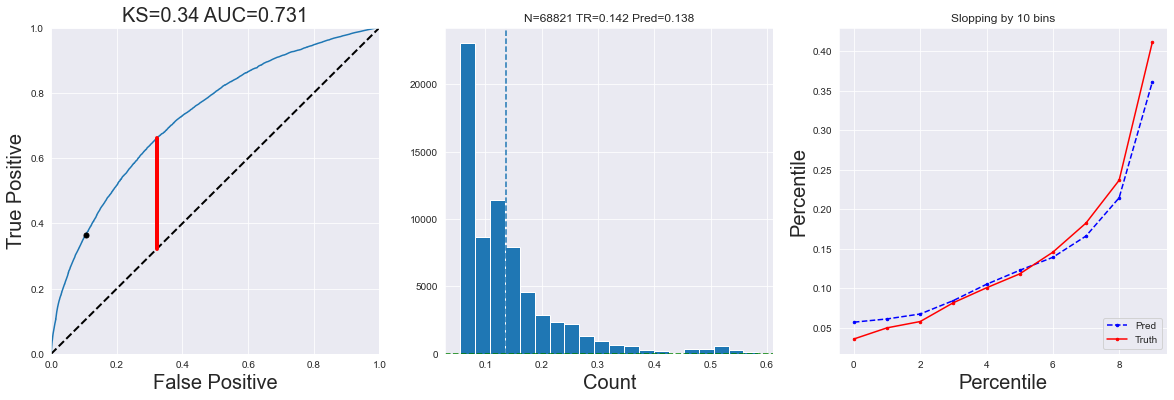

In [14]:
train_plot = plot_all(target=train['target'].reset_index(drop=True), predicted=y_train_pred)
oot_plot = plot_all(target=df_oot['target'].reset_index(drop=True), predicted=y_oot_pred)